[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GiacomoRattazzi/LLMsPoliticalBias/blob/main/code/PoliticalBiasBERT%20Validation/BASIL/BASIL_Accuracy.ipynb)


# Table of Contents

>[Table of Contents](#scrollTo=qBESdJ95WNr8)

>[1. Importing packages and functions](#scrollTo=tQTSZcDVchjE)

>>[1.1 HuggingFace login](#scrollTo=T8XrSdVgU8jj)

>[2. Token Length Visualization](#scrollTo=Fc4VbG4m6cCv)

>[3. Functions](#scrollTo=IxEOsUvO89_9)

>>[3.1 Functions to chunk by either sentences or max tokens](#scrollTo=IFK01OYT8_8f)

>>[3.2 Chunking Functions Tests](#scrollTo=xvLHdPaOUE9m)

>>[3.3 Function to get predicted stance with BERT model](#scrollTo=1bVRG0dj9NBU)

>[4. Running BERT model](#scrollTo=oYXxW5ZV9TyI)

>>[4.1 Chunking by tokens](#scrollTo=WWst2vZn9goJ)

>>[4.2 Chunking by sentences](#scrollTo=rnuC_UCA9oh_)

>[5. Other tests to validate results](#scrollTo=26XcUw-moJGY)



# 1. Importing packages and functions

In [ ]:
pip install sklearn matplotlib

In [ ]:
pip install transformers

In [ ]:
pip install huggingface_hub datasets

In [ ]:
pip install --upgrade huggingface_hub

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1.1 HuggingFace login

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

> Downloading dataset

In [ ]:
from huggingface_hub import hf_hub_download

# Assuming you're trying to download a specific file from the dataset repository
repo_id = "GiacR/LLMsPoliticalBias"  # Your dataset repository name
filename = "BASIL/data.zip"  # The specific file you want to download
use_auth_token = True  # Ensure you're authenticated to access private datasets

# Download the file
file_path = hf_hub_download(repo_id=repo_id, filename=filename, repo_type="dataset", use_auth_token=use_auth_token)

print(f"File downloaded at: {file_path}")

In [ ]:
!unzip -o {file_path}  # Unzip in the current working directory

# 2. Token Length Visualization

       File Name  Token Length
0     7_hpo.json           602
1    56_fox.json          1007
2    96_NYT.json           547
3    30_fox.json           631
4    60_nyt.json          1743
..           ...           ...
295   6_fox.json          1149
296  21_fox.json          1027
297   7_nyt.json          1795
298  92_fox.json           545
299  85_nyt.json          1066

[300 rows x 2 columns]

Statistical Measures:
Mean Token Length: 858.17
Median Token Length: 818.5
Maximum Token Length: 2378
Minimum Token Length: 255


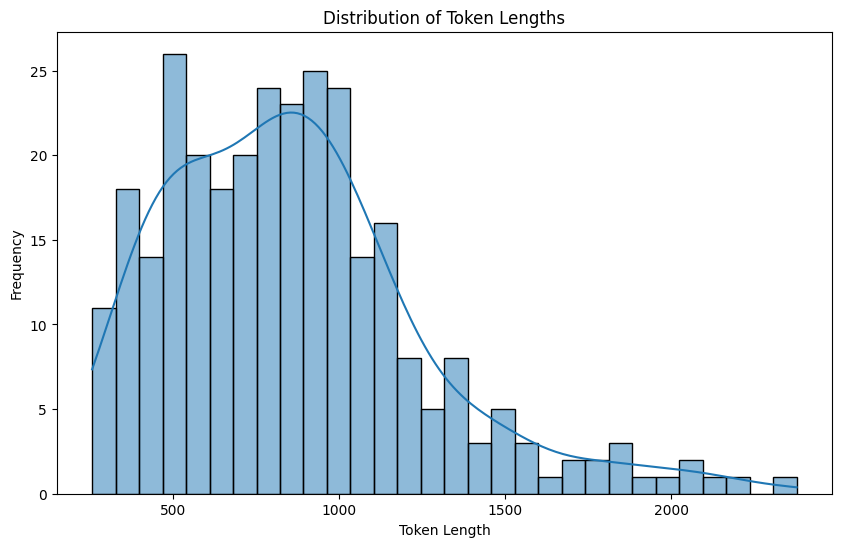

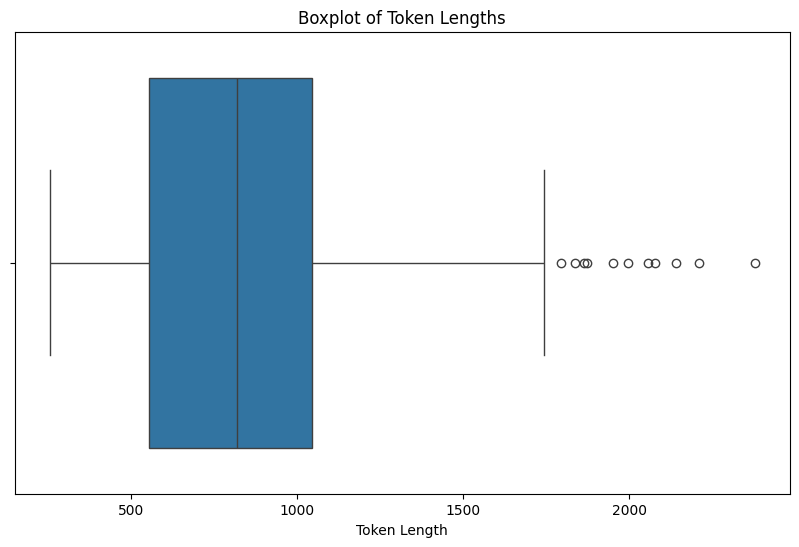

In [ ]:
# Path to the data folder
data_folder = '/content/data'

# Lists to store file names and their corresponding token lengths
file_names = []
token_lengths = []

# Processing each file
all_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.json')]
for file in all_files:
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']
    body = " ".join([sent['sentence'] for sent in article['body']])
    full_text = title + " " + body

    # Calculate total number of tokens
    total_tokens = len(tokenizer.encode(full_text, add_special_tokens=True))

    # Append results to lists
    file_names.append(os.path.basename(file))
    token_lengths.append(total_tokens)

# Create a DataFrame
df = pd.DataFrame({
    'File Name': file_names,
    'Token Length': token_lengths
})

# Display the DataFrame
print(df)

# Calculate and display statistical measures
print("\nStatistical Measures:")
print(f"Mean Token Length: {df['Token Length'].mean()}")
print(f"Median Token Length: {df['Token Length'].median()}")
print(f"Maximum Token Length: {df['Token Length'].max()}")
print(f"Minimum Token Length: {df['Token Length'].min()}")

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(df['Token Length'], bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Token Length'])
plt.title('Boxplot of Token Lengths')
plt.xlabel('Token Length')
plt.show()

# 3. Functions

## 3.1 Functions to chunk by either sentences or max tokens

In [ ]:
# Define stance mapping
stance_mapping = {0: "left", 1: "center", 2: "right"}

def chunk_text_by_tokens(text, max_tokens):
    # Tokenize the text and get the token ids
    token_ids = tokenizer.encode(text, add_special_tokens=False)

    # Initialize chunks
    chunks = []
    current_chunk_token_ids = []

    for token_id in token_ids:
        if len(current_chunk_token_ids) + 1 > max_tokens:
            # Convert token ids to text and add to chunks
            chunks.append(current_chunk_token_ids)
            current_chunk_token_ids = [token_id]
        else:
            current_chunk_token_ids.append(token_id)

    # Add last chunk
    if current_chunk_token_ids:
        chunks.append(current_chunk_token_ids)

    return chunks

# Function to chunk text by sentences
def chunk_text_by_sentences(text, max_tokens):
    sentences = sent_tokenize(text)
    token_chunks = []
    current_chunk = []

    for sentence in sentences:
        sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
        if len(current_chunk) + len(sentence_tokens) > max_tokens:
            token_chunks.append(current_chunk)
            current_chunk = sentence_tokens
        else:
            current_chunk.extend(sentence_tokens)

    if current_chunk:
        token_chunks.append(current_chunk)

    return token_chunks

## 3.2 Chunking Functions Tests

In [ ]:
# Sample text
sample_text = "This is a sample text. We will use this to test our functions. It contains multiple sentences."

max_tokens = 10

# Chunk the text using both methods
chunks_by_tokens = chunk_text_by_tokens(sample_text, max_tokens)
chunks_by_sentences = chunk_text_by_sentences(sample_text, max_tokens)

# Function to check the structure and content of the chunks
def analyze_chunks(chunks, method_name):
    print(f"Chunks from {method_name}:")
    for i, chunk in enumerate(chunks):
        print(f" Chunk {i+1} (length {len(chunk)}): {chunk}")

    if all(isinstance(chunk, list) for chunk in chunks):
        print(f"All chunks in {method_name} are lists.\n")
    else:
        print(f"Some chunks in {method_name} are not lists.\n")

# Analyze and compare
print("Analyzing Chunk Structures and Contents\n")

print("By Tokens Method:")
analyze_chunks(chunks_by_tokens, "By Tokens")

print("By Sentences Method:")
analyze_chunks(chunks_by_sentences, "By Sentences")


Analyzing Chunk Structures and Contents

By Tokens Method:
Chunks from By Tokens:
 Chunk 1 (length 10): [1188, 1110, 170, 6876, 3087, 119, 1284, 1209, 1329, 1142]
 Chunk 2 (length 10): [1106, 2774, 1412, 4226, 119, 1135, 2515, 2967, 12043, 119]
All chunks in By Tokens are lists.

By Sentences Method:
Chunks from By Sentences:
 Chunk 1 (length 6): [1188, 1110, 170, 6876, 3087, 119]
 Chunk 2 (length 9): [1284, 1209, 1329, 1142, 1106, 2774, 1412, 4226, 119]
 Chunk 3 (length 5): [1135, 2515, 2967, 12043, 119]
All chunks in By Sentences are lists.



In [ ]:
probs_list = []
for chunk in chunks_by_tokens:
    print("CHUNK ID")
    print(chunk)
    chunk_text = tokenizer.decode(chunk)
    print("DECODED CHUNK")
    print(chunk_text)
    inputs = tokenizer(chunk_text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)

    # Pass the inputs to the model
    outputs = model(**inputs)
    logits = outputs.logits
    probs = logits.softmax(dim=-1).squeeze().tolist()
    print("PROBS")
    print(probs)
    probs_list.append(probs)

# Calculate the median probabilities
probs_array = np.array(probs_list)
median_probs = np.median(probs_array, axis=0)
predicted_stance = stance_mapping[np.argmax(median_probs)]
print("PROBS ARRAY")
print(probs_array)
print("MEDIAN")
print(median_probs)
print(predicted_stance)

CHUNK ID
[1188, 1110, 170, 6876, 3087, 119, 1284, 1209, 1329, 1142]
DECODED CHUNK
This is a sample text. We will use this
PROBS
[0.27364012598991394, 0.2380804717540741, 0.48827946186065674]
CHUNK ID
[1106, 2774, 1412, 4226, 119, 1135, 2515, 2967, 12043, 119]
DECODED CHUNK
to test our functions. It contains multiple sentences.
PROBS
[0.3383803367614746, 0.2246384620666504, 0.4369811713695526]
PROBS ARRAY
[[0.27364013 0.23808047 0.48827946]
 [0.33838034 0.22463846 0.43698117]]
MEDIAN
[0.30601023 0.23135947 0.46263032]
right


## 3.3 Function to get predicted stance with BERT model

In [ ]:
# Function to get model prediction
def get_model_prediction(text_chunks):
    probs_list = []
    for chunk in text_chunks:
        # Convert token ids to text
        chunk_text = tokenizer.decode(chunk)

        # Tokenize the text
        inputs = tokenizer(chunk_text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)

        # Pass the inputs to the model
        outputs = model(**inputs)
        logits = outputs.logits
        probs = logits.softmax(dim=-1).squeeze().tolist()
        probs_list.append(probs)

    # Calculate the median probabilities
    probs_array = np.array(probs_list)
    median_probs = np.median(probs_array, axis=0)
    predicted_stance = stance_mapping[np.argmax(median_probs)]

    return predicted_stance

# 4. Running BERT model

In [ ]:
# Load JSON files
data_dir = "./data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

## 4.1 Chunking by tokens

Processing with max_length = 128


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 128: 0.2833
              precision    recall  f1-score   support

      center       0.56      0.03      0.07       144
        left       0.24      0.20      0.22        81
       right       0.29      0.85      0.43        75

    accuracy                           0.28       300
   macro avg       0.36      0.36      0.24       300
weighted avg       0.40      0.28      0.20       300



<Figure size 1000x700 with 0 Axes>

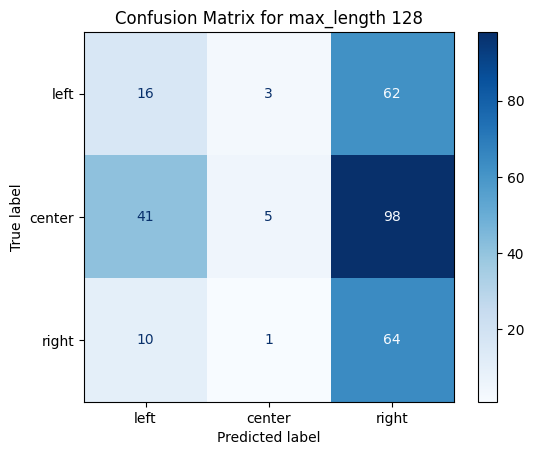

Processing with max_length = 256


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 256: 0.3367
              precision    recall  f1-score   support

      center       0.62      0.19      0.30       144
        left       0.23      0.22      0.22        81
       right       0.31      0.73      0.44        75

    accuracy                           0.34       300
   macro avg       0.39      0.38      0.32       300
weighted avg       0.44      0.34      0.31       300



<Figure size 1000x700 with 0 Axes>

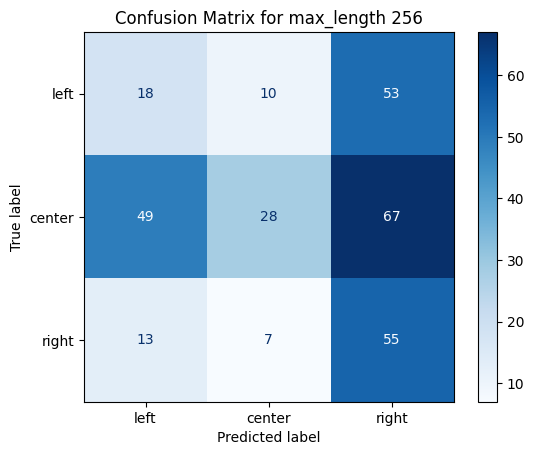

Processing with max_length = 512


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 512: 0.3967
              precision    recall  f1-score   support

      center       0.51      0.46      0.48       144
        left       0.24      0.20      0.21        81
       right       0.36      0.49      0.42        75

    accuracy                           0.40       300
   macro avg       0.37      0.38      0.37       300
weighted avg       0.40      0.40      0.39       300



<Figure size 1000x700 with 0 Axes>

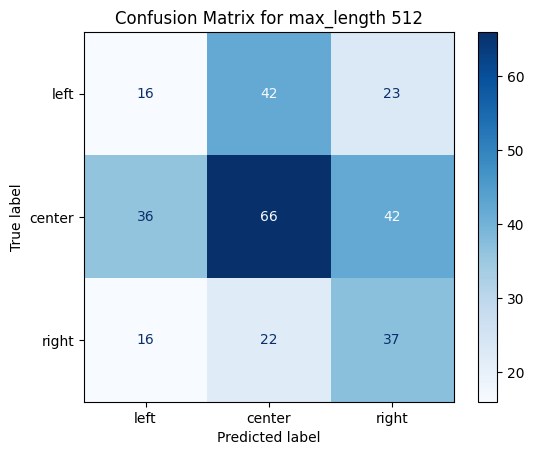

Processing with max_length = 1024


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 1024: 0.4500
              precision    recall  f1-score   support

      center       0.49      0.65      0.56       144
        left       0.24      0.16      0.19        81
       right       0.52      0.39      0.44        75

    accuracy                           0.45       300
   macro avg       0.42      0.40      0.40       300
weighted avg       0.43      0.45      0.43       300



<Figure size 1000x700 with 0 Axes>

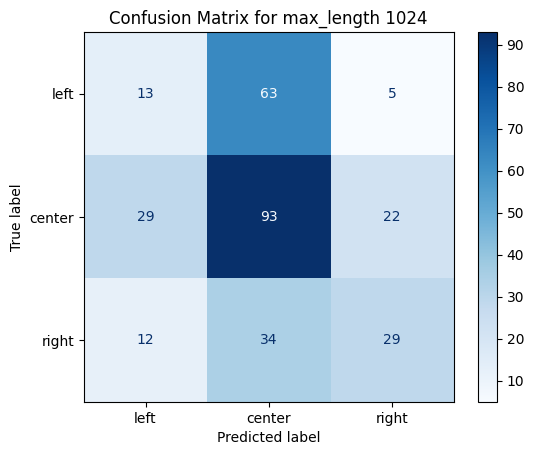

Processing with max_length = 2048


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 2048: 0.4733
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.27      0.15      0.19        81
       right       0.54      0.41      0.47        75

    accuracy                           0.47       300
   macro avg       0.44      0.42      0.41       300
weighted avg       0.45      0.47      0.45       300



<Figure size 1000x700 with 0 Axes>

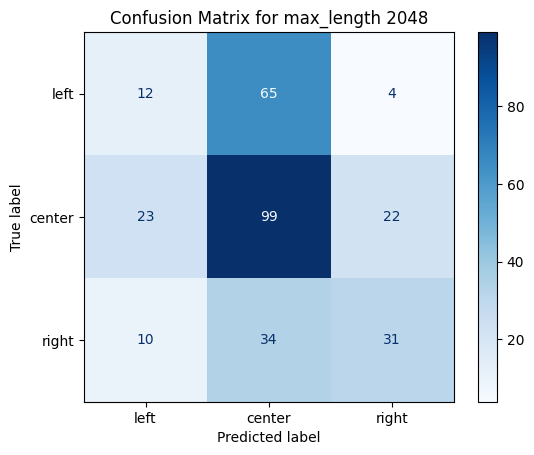

In [ ]:
# Iterate over different max lengths
for max_length in [128, 256, 512, 1024, 2048]:
    print(f"Processing with max_length = {max_length}")
    true_labels = []
    predicted_labels = []

    for file in tqdm(all_files):
        with open(file, 'r') as f:
            article = json.load(f)

        title = article['title']
        body = " ".join([sent['sentence'] for sent in article['body']])
        full_text = title + " " + body
        true_labels.append(article['article-level-annotations']['stance'].lower())

        # Chunking method: by tokens or by sentences
        text_chunks = chunk_text_by_tokens(full_text, max_length)
        # text_chunks = chunk_text_by_sentences(full_text, max_length)

        predicted_labels.append(get_model_prediction(text_chunks))

        new_row = pd.DataFrame({
            'FileName': [os.path.basename(file)],
            'NumTokens': [len(tokenizer.encode(full_text))],
            'FullText': [full_text]
        })
        info_df = pd.concat([info_df, new_row], ignore_index=True)

    # Evaluate and plot
    df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for max_length {max_length}: {accuracy:.4f}")
    print(classification_report(true_labels, predicted_labels))

    ordered_labels = ['left', 'center', 'right']
    matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=ordered_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ordered_labels)
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for max_length {max_length}")
    plt.show()

## 4.2 Chunking by sentences

Processing with max_length = 128


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 128: 0.2967
              precision    recall  f1-score   support

      center       1.00      0.02      0.04       144
        left       0.34      0.20      0.25        81
       right       0.28      0.93      0.43        75

    accuracy                           0.30       300
   macro avg       0.54      0.38      0.24       300
weighted avg       0.64      0.30      0.19       300



<Figure size 1000x700 with 0 Axes>

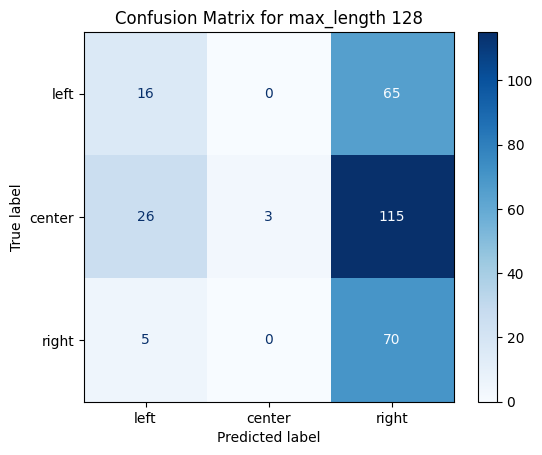

Processing with max_length = 256


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 256: 0.3233
              precision    recall  f1-score   support

      center       0.64      0.16      0.26       144
        left       0.29      0.28      0.29        81
       right       0.28      0.68      0.39        75

    accuracy                           0.32       300
   macro avg       0.40      0.37      0.31       300
weighted avg       0.45      0.32      0.30       300



<Figure size 1000x700 with 0 Axes>

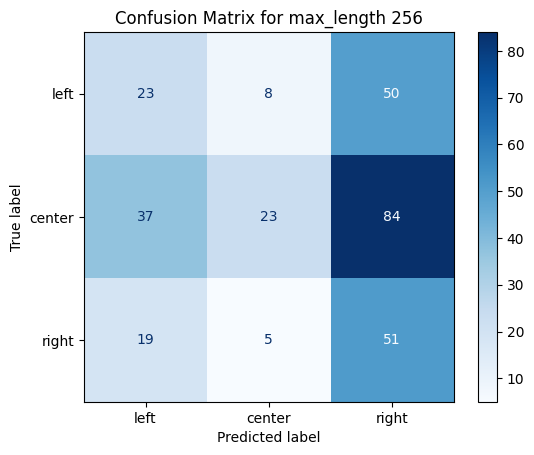

Processing with max_length = 512


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
# Iterate over different max lengths
for max_length in [128, 256, 512, 1024, 2048]:
    print(f"Processing with max_length = {max_length}")
    true_labels = []
    predicted_labels = []

    for file in tqdm(all_files):
        with open(file, 'r') as f:
            article = json.load(f)
        title = article['title']
        body = " ".join([sent['sentence'] for sent in article['body']])
        full_text = title + " " + body
        true_labels.append(article['article-level-annotations']['stance'].lower())

        # Chunking method: by tokens or by sentences
        # text_chunks = chunk_text_by_tokens(full_text, max_length)
        text_chunks = chunk_text_by_sentences(full_text, max_length)

        predicted_labels.append(get_model_prediction(text_chunks))

        new_row = pd.DataFrame({
            'FileName': [os.path.basename(file)],
            'NumTokens': [len(tokenizer.encode(full_text))],
            'FullText': [full_text]
        })


    # Evaluate and plot
    df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for max_length {max_length}: {accuracy:.4f}")
    print(classification_report(true_labels, predicted_labels))

    ordered_labels = ['left', 'center', 'right']
    matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=ordered_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ordered_labels)
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for max_length {max_length}")
    plt.show()

# 5. Other tests to validate results


In [ ]:
for max_length in [128, 256, 512, 1024, 2048]:
    print(f"Processing with max_length = {max_length}")
    true_labels = []
    predicted_labels = []
    data_for_csv = []  # List to store data for CSV

    for file in tqdm(all_files):
        with open(file, 'r') as f:
            article = json.load(f)

        title = article['title']
        body = " ".join([sent['sentence'] for sent in article['body']])
        full_text = title + " " + body
        true_lab = article['article-level-annotations']['stance'].lower()
        true_labels.append(article['article-level-annotations']['stance'].lower())

        text_chunks = chunk_text_by_tokens(full_text, max_length)


        probs_list = []
        for chunk in text_chunks:
            # Convert token ids to text
            chunk_text = tokenizer.decode(chunk)

            # Tokenize the text
            inputs = tokenizer(chunk_text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)

            # Pass the inputs to the model
            outputs = model(**inputs)
            logits = outputs.logits
            probs = logits.softmax(dim=-1).squeeze().tolist()
            probs_list.append(probs)

            data_for_csv.append({
                'ArticleID': os.path.basename(file),
                'TrueLabel': true_lab,
                'ChunkText': chunk_text,
                'ResultsProbabilities': probs
            })

    # Save data to CSV
    csv_df = pd.DataFrame(data_for_csv)
    csv_filename = f"output_max_length_{max_length}.csv"
    csv_df.to_csv(csv_filename, index=False)

Processing with max_length = 128


  0%|          | 0/300 [00:00<?, ?it/s]

Processing with max_length = 256


  0%|          | 0/300 [00:00<?, ?it/s]

Processing with max_length = 512


  0%|          | 0/300 [00:00<?, ?it/s]

Processing with max_length = 1024


  0%|          | 0/300 [00:00<?, ?it/s]

Processing with max_length = 2048


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
from google.colab import files

In [ ]:
for length in [128, 256, 512, 1024, 2048]:
    csv_filename = f"output_max_length_{str(length)}.csv"
    files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for max_length in [128, 256, 512, 1024, 2048]:
    print(f"Processing with max_length = {max_length}")
    true_labels = []
    predicted_labels = []
    data_for_csv = []  # List to store data for CSV

    for file in tqdm(all_files):
        with open(file, 'r') as f:
            article = json.load(f)

        title = article['title']
        body = " ".join([sent['sentence'] for sent in article['body']])
        full_text = title + " " + body
        true_lab = article['article-level-annotations']['stance'].lower()
        true_labels.append(article['article-level-annotations']['stance'].lower())

        text_chunks = chunk_text_by_sentences(full_text, max_length)


        probs_list = []
        for chunk in text_chunks:
            # Convert token ids to text
            chunk_text = tokenizer.decode(chunk)

            # Tokenize the text
            inputs = tokenizer(chunk_text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)

            # Pass the inputs to the model
            outputs = model(**inputs)
            logits = outputs.logits
            probs = logits.softmax(dim=-1).squeeze().tolist()
            probs_list.append(probs)

            data_for_csv.append({
                'ArticleID': os.path.basename(file),
                'TrueLabel': true_lab,
                'ChunkText': chunk_text,
                'ResultsProbabilities': probs
            })

    # Save data to CSV
    csv_df = pd.DataFrame(data_for_csv)
    csv_filename = f"output_max_length_{max_length}_sent.csv"
    csv_df.to_csv(csv_filename, index=False)

Processing with max_length = 128


  0%|          | 0/300 [00:00<?, ?it/s]

Processing with max_length = 256


  0%|          | 0/300 [00:00<?, ?it/s]

Processing with max_length = 512


  0%|          | 0/300 [00:00<?, ?it/s]

Processing with max_length = 1024


  0%|          | 0/300 [00:00<?, ?it/s]

Processing with max_length = 2048


  0%|          | 0/300 [00:00<?, ?it/s]

In [ ]:
import ast
# Function to extract probabilities
def extract_probabilities(prob_string):
    prob_list = ast.literal_eval(prob_string)
    return prob_list[0], prob_list[1], prob_list[2]

In [ ]:
results = {}
for length in  [128, 256, 512, 1024, 2048]:
    # Read CSV
    df = pd.read_csv(f'output_max_length_{length}_sent.csv')

    df[['ProbLeft', 'ProbCenter', 'ProbRight']] = df['ResultsProbabilities']\
    .str.strip('[]')\
    .str.split(',', expand=True)\
    .astype(float)

    # Group by 'ArticleID' and calculate median
    df_median = df.groupby('ArticleID')[['ProbLeft', 'ProbCenter', 'ProbRight']].median()

    # Find the maximum probability among the three and assign the corresponding label
    df_median['PredictedLabel'] = df_median.idxmax(axis=1).str.replace('Prob', '').str.lower()

    # Calculate accuracy by comparing PredictedLabel with TrueLabel
    accuracy = (df.groupby('ArticleID')['TrueLabel'].first() == df_median['PredictedLabel']).mean()

    # Store the result
    results[length] = accuracy

results

{128: 0.2966666666666667,
 256: 0.3233333333333333,
 512: 0.4066666666666667,
 1024: 0.4633333333333333,
 2048: 0.47333333333333333}

In [ ]:
results = {}
for length in  [128, 256, 512, 1024, 2048]:
    # Read CSV
    df = pd.read_csv(f'output_max_length_{length}.csv')

    df[['ProbLeft', 'ProbCenter', 'ProbRight']] = df['ResultsProbabilities']\
    .str.strip('[]')\
    .str.split(',', expand=True)\
    .astype(float)

    # Group by 'ArticleID' and calculate median
    df_median = df.groupby('ArticleID')[['ProbLeft', 'ProbCenter', 'ProbRight']].median()

    # Find the maximum probability among the three and assign the corresponding label
    df_median['PredictedLabel'] = df_median.idxmax(axis=1).str.replace('Prob', '').str.lower()

    # Calculate accuracy by comparing PredictedLabel with TrueLabel
    accuracy = (df.groupby('ArticleID')['TrueLabel'].first() == df_median['PredictedLabel']).mean()

    # Store the result
    results[length] = accuracy

results

{128: 0.2833333333333333,
 256: 0.33666666666666667,
 512: 0.39666666666666667,
 1024: 0.45,
 2048: 0.47333333333333333}

In [ ]:
df

,ArticleID,TrueLabel,ChunkText,ResultsProbabilities,ProbLeft,ProbCenter,ProbRight
0,17_fox.json,center,RNC Chairman Steele to Announce Intentions on ...,"[0.2902686595916748, 0.03664147108793259, 0.67...",0.290269,0.036641,0.673090
1,98_hpo.json,center,Top House Republican Hints At Immigration Prin...,"[0.005912013817578554, 0.9916068315505981, 0.0...",0.005912,0.991607,0.002481
2,7_hpo.json,left,House Intelligence Committee Republicans Deman...,"[0.015245203860104084, 0.9717603921890259, 0.0...",0.015245,0.971760,0.012994
3,13_nyt.json,center,"For Now, Trump to Keep Ban on Importing Elepha...","[0.00128940399736166, 0.9941850304603577, 0.00...",0.001289,0.994185,0.004526
4,8_hpo.json,left,Marco Rubio Lays Out Hawkish Foreign Policy Do...,"[0.02127116732299328, 0.9720839262008667, 0.00...",0.021271,0.972084,0.006645
...,...,...,...,...,...,...,...
300,73_hpo.json,left,Richard Blumenthal Calls NYT Report'Outrageous...,"[0.06890711188316345, 0.9209656119346619, 0.01...",0.068907,0.920966,0.010127
301,78_fox.json,right,Benghazi emails underscore State Department ’ ...,"[0.24575620889663696, 0.041582293808460236, 0....",0.245756,0.041582,0.712662
302,75_fox.json,center,"As Mueller findings released, 2020 Dems demand...","[0.8531240224838257, 0.014578127302229404, 0.1...",0.853124,0.014578,0.132298
303,60_hpo.json,left,Donald Trump Vows To End Birthright Citizenshi...,"[0.017495887354016304, 0.975236177444458, 0.00...",0.017496,0.975236,0.007268


In [ ]:
grouped

,ProbLeft,ProbCenter,ProbRight
ArticleID,,,
0_fox.json,0.045217,0.009944,0.944839
0_hpo.json,0.002623,0.995198,0.002179
0_nyt.json,0.003572,0.992766,0.003662
10_fox.json,0.003501,0.994296,0.002203
10_hpo.json,0.001656,0.995757,0.002587
...,...,...,...
99_hpo.json,0.010532,0.981755,0.007713
99_nyt.json,0.002333,0.993309,0.004358
9_fox.json,0.351902,0.076023,0.572075
